# Saw time series

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable  # CHECK: do I need this?

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import time


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Simulate data

In [425]:
torch.manual_seed(2012)

N = 1000
theta = torch.tensor([3.4159])
a = 0.75
z = torch.empty(N)
x = torch.empty(N + 1)
x[0] = 0
for n in range(N):
    z[n] = torch.randn(1) + x[n]
    x[n + 1] = torch.randn(1) + a * (theta + x[n])


In [ ]:
plt.plot(x, alpha = 0.5)
plt.plot(z, alpha = 0.5)

### Distributions for ELBO

In [427]:
# Vectorized for Monte Carlo estimation of the ELBO
def log_joint(x, theta, z):
  return -0.5 * torch.sum((z - x[:N])**2, dim = 1)\
    - 0.5 * torch.sum((x[1:] - a * (z + theta))**2, dim = 1)

def log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = torch.sum(- torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2, dim = 1)
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2)\
                          * (z - nu_mean_z)**2, dim = 1)
    return log_q_theta + log_q_z


In [428]:
# SANITY CHECK
if False:
    N_mc = 10
    theta = theta.to(device).repeat(N_mc).reshape(N_mc, 1)
    z = z.to(device).repeat(N_mc).reshape(N_mc, N)
    x = x.to(device)
    nu_mean_theta = torch.randn(1).to(device)
    nu_sd_theta = torch.exp(torch.randn(1)).to(device)
    nu_mean_z = torch.randn(N).to(device)
    nu_sd_z = torch.exp(torch.randn(N)).to(device)

    print(log_joint(x, theta, z))
    print(log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z))

### Model class for VI

In [429]:
class Inference_NN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Inference_NN, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, 1)
        self.FC_sd_log = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h_ = F.relu(self.FC_input(x))
        h_ = F.relu(self.FC_input2(h_))
        mean = self.FC_mean(h_).reshape(N)
        sd_log = self.FC_sd_log(h_).reshape(N)

        return mean, sd_log


In [430]:
class Model(nn.Module):
    def __init__(self, input_dim = 1,
                 use_avi = False, hidden_dim = 0, const_z = False, N_mc = 100):
        super(Model, self).__init__()
        self.use_avi = use_avi
        self.const_z = const_z
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # variational parameters for q(theta)
        self.nu_mean_theta = torch.nn.Parameter(torch.randn(1))
        self.nu_sd_theta_log = torch.nn.Parameter(torch.randn(1))

        # variational parameters for q(z)
        if (const_z and (not use_avi)):
            self.nu_mean_z = torch.nn.Parameter(torch.randn(1))
            self.nu_sd_z_log = torch.nn.Parameter(torch.randn(1))
        elif (use_avi):
            self.inference_nn = Inference_NN(input_dim, hidden_dim)
        else:
            self.nu_mean_z = torch.nn.Parameter(torch.randn(N))
            self.nu_sd_z_log = torch.nn.Parameter(torch.randn(N))
        
        self.N_mc = N_mc

    def reparam(self, nu_mean_z, nu_sd_z, nu_mean_theta, nu_sd_theta, N_mc):
        epsilon = torch.randn((N_mc, N)).to(device)
        z = nu_mean_z + nu_sd_z * epsilon
        
        epsilon_theta = torch.randn((N_mc, 1)).to(device)
        theta = nu_mean_theta + nu_sd_theta * epsilon_theta

        return z, theta
    
    def variational_z(self, x):
        if (self.use_avi and self.input_dim == 1):
            nu_mean_z, nu_sd_z_log = self.inference_nn(x[1:].reshape(N, 1))
        elif (self.use_avi and self.input_dim == 2):
            x_input = torch.transpose(torch.stack([x[:N], x[1:]]), 0, 1)
            nu_mean_z, nu_sd_z_log = self.inference_nn(x_input)
        elif (self.const_z):
            nu_mean_z = self.nu_mean_z.repeat(N)
            nu_sd_z_log = self.nu_sd_z_log.repeat(N)
        else:
            nu_mean_z = self.nu_mean_z
            nu_sd_z_log = self.nu_sd_z_log
        return nu_mean_z, torch.exp(nu_sd_z_log)
    
    def compute_elbo(self, x):
        nu_mean_z, nu_sd_z = self.variational_z(x)
        z, theta = self.reparam(nu_mean_z, nu_sd_z,
                                self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                                self.N_mc)
        Elbo = log_joint(x, theta, z)\
            - log_q(theta, z, self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                    nu_mean_z, nu_sd_z)
        return torch.mean(Elbo)


### Run VI

In [499]:
def run_vi(seed, n_iter_optimizer, use_avi=False, input_dim=1, hidden_dim=0, const_z=False,
           print_output=False):
    torch.manual_seed(seed)

    model = Model(input_dim, use_avi, hidden_dim, const_z).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    loss_saved = torch.empty(n_iter_optimizer)

    start_time = time.time()
    for i in range(n_iter_optimizer):
            loss = - model.compute_elbo(x.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_saved[i] = loss.data
            if (i % 1000 == 0 and print_output):
                print("loss", loss_saved[i])
    end_time = time.time()
    run_time = end_time - start_time

    return loss_saved, model, run_time

In [ ]:
plt.style.use('seaborn-white')  # seaborn-v0_8-white

params = {'axes.labelsize': 18,'axes.titlesize':25, 'legend.fontsize': 15, 'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(params)

linewidth = 4

In [ ]:
# manual examine a few tuning parameters for A-VI.
if (False):
    seed = 2012
    n_iter_optimizer = int(30e3)

    n_method = 9
    loss_all = torch.empty((n_method, n_iter_optimizer))

    loss_all[0,:], model_fvi = run_vi(seed, n_iter_optimizer)
    loss_all[1,:], model_const = run_vi(seed, n_iter_optimizer, const_z=True)
    loss_all[2,:], model_avi_4 = run_vi(seed, n_iter_optimizer, use_avi=True, hidden_dim=4)
    loss_all[3,:], _ = run_vi(seed, n_iter_optimizer, use_avi=True, hidden_dim=6)
    loss_all[4,:], model_avi_10 = run_vi(seed, n_iter_optimizer, use_avi=True, hidden_dim=10)
    loss_all[5,:], model_av2_1 = run_vi(seed, n_iter_optimizer, use_avi=True, input_dim=2, hidden_dim=1)
    loss_all[6,:], model_av2_2 = run_vi(seed, n_iter_optimizer, use_avi=True, input_dim=2, hidden_dim=2)
    loss_all[7,:], model_av2_3 = run_vi(seed, n_iter_optimizer, use_avi=True, input_dim=2, hidden_dim=3)
    loss_all[8,:], model_av2_4 = run_vi(seed, n_iter_optimizer, use_avi=True, input_dim=2, hidden_dim=4)
    loss_x2k6, _ = run_vi(2013, n_iter_optimizer, use_avi=True, input_dim=2, hidden_dim=6)
    loss_x2k10, _ = run_vi(2013, n_iter_optimizer, use_avi=True, input_dim=2, hidden_dim=10)
    loss_x1k20, _ = run_vi(2013, n_iter_optimizer, use_avi=True, input_dim=1, hidden_dim=20)
    
    algo_names = ['F-VI', 'const', 'n=1, k=4', 'n=1, k=6', 'n=1, k=10', 'n=2, k=4']

    plt.plot(loss_all[0,:] + min_elbo, color = 'black', label = 'F-VI', linewidth = linewidth)
    plt.plot(loss_all[1,:] + min_elbo, color = 'red', label = 'const', linewidth = linewidth)
    plt.plot(loss_x1k20 + min_elbo, alpha = 0.5, label = "n=1, k=20", linewidth = linewidth)
    plt.plot(loss_all[8,:] + min_elbo, alpha = 0.5, label = "n=2, k=4", linewidth = linewidth)

    plt.gca().invert_yaxis()
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel("Elbo")
    plt.grid(which = 'major', visible = 'true', c = 'grey', alpha = 0.25)

    plt.savefig("to_discuss/k_vae_time_series.pdf", bbox_inches = 'tight')

### Run experiment

In [530]:
def run_experiment(seed, n_iter_optimizer, nn_widths, nn_inputs):
    loss_all = np.empty((n_iter_optimizer, 2 + nn_widths.size))
    saved_times = np.empty(2 + nn_widths.size)

    loss_all[:,0], _, saved_times[0] = run_vi(seed, n_iter_optimizer)  # FVI
    loss_all[:,1], _, saved_times[1] = run_vi(seed, n_iter_optimizer, const_z=True)

    for i in range(nn_widths.size):
        loss_all[:,i+2], _, saved_times[2] = run_vi(seed, n_iter_optimizer, use_avi=True,
                                                    input_dim=nn_inputs[i],
                                                    hidden_dim=nn_widths[i])
    
    np.save("deliv/timeseries_loss_" + str(seed), loss_all)
    np.save("deliv/timeseries_time_" + str(seed), saved_times)


In [504]:
n_iter_optimizer = int(30e3)

nn_widths = np.array([4, 6, 10, 20, 2, 4, 6, 10])
nn_inputs = np.array([1, 1, 1, 1, 2, 2, 2, 2])

init_seed = 2013
for i in range(10):
    seed = init_seed + i
    print("seed ", seed)
    run_experiment(seed, n_iter_optimizer, nn_widths, nn_inputs)


seed  2013
seed  2014
seed  2015
seed  2016
seed  2017
seed  2018
seed  2019
seed  2020
seed  2021
seed  2022


### Analyze results

In [41]:
plt.style.use('seaborn-white')  # seaborn-v0_8-white

params = {'axes.labelsize': 18,'axes.titlesize':25, 'legend.fontsize': 20, 'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(params)

/tmp/ipykernel_773600/4224304255.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # seaborn-v0_8-white


In [4]:
seed = 2013
loss_all = np.load("deliv/timeseries_loss_" + str(seed) + ".npy")

In [10]:
nn_widths = np.array([4, 6, 10, 20, 2, 4, 6, 10])
nn_inputs = np.array([1, 1, 1, 1, 2, 2, 2, 2])

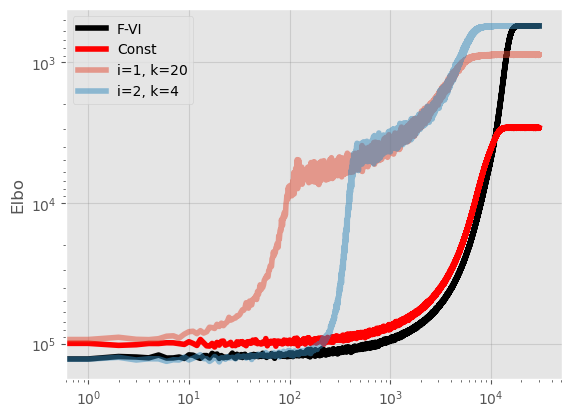

In [6]:
linewidth=4
plt.plot(loss_all[:,0], color = 'black', label = 'F-VI', linewidth = linewidth)
plt.plot(loss_all[:,1], color = 'red', label = 'Const', linewidth = linewidth)
plt.plot(loss_all[:,5], alpha = 0.5, label = "i=1, k=20", linewidth = linewidth)
plt.plot(loss_all[:,7], alpha = 0.5, label = "i=2, k=4", linewidth = linewidth)

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.gca().invert_yaxis()
plt.ylabel("Elbo")
plt.grid(which = 'major', visible = 'true', c = 'grey', alpha = 0.25)

plt.savefig("to_discuss/k_vae_time_series.pdf", bbox_inches = 'tight')


In [11]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)]) 


In [12]:
n_iter_optimizer = int(30000)

In [13]:
window = 500
index_center = n_iter_optimizer - window
print("FVI: ", mean_window(loss_all[:, 0], index_center, window), " +/- ",
      sd_window(loss_all[:, 0], index_center, window))

print("Const: ", mean_window(loss_all[:, 1], index_center, window), " +/- ",
      sd_window(loss_all[:, 1], index_center, window))

for i in range(nn_widths.size):
  print("k = " + str(nn_widths[i]) + ": ", mean_window(loss_all[:, i + 2],
        index_center, window), " +/- ",
        sd_window(loss_all[:, i], index_center, window))


FVI:  553.0837867431641  +/-  0.06985303834506525
Const:  2933.555895751953  +/-  6.7674346535909455
k = 4:  891.9649091796875  +/-  0.06985303834506525
k = 6:  892.8204157714844  +/-  6.7674346535909455
k = 10:  886.1229639892579  +/-  2.5709975260837434
k = 20:  886.220542541504  +/-  2.5966791410048455
k = 2:  2933.6476901855467  +/-  2.588699204945348
k = 4:  553.0766517333984  +/-  2.5385311546707383
k = 6:  553.0869779052734  +/-  7.0208861080178
k = 10:  553.116260925293  +/-  0.10228968027303144


In [14]:
def iter_convergence(loss, rel_tol = 0.01, init_iteration = 10, window = 10,
                     grid = 10, max_iteration = 20000, oracle = True, set_target = 0):
    iteration = init_iteration
    tol = 0
    diff = tol + 1
    while(diff > tol and iteration < max_iteration):
        iteration += grid
        if (oracle):
            target = set_target
        else:
            target = mean_window(loss, iteration - grid, window)

        tol = rel_tol * abs(target)
        diff = abs(mean_window(loss, iteration, window) - target)
        # print("diff:", diff)
        # print("tol:", tol)
    return iteration

# Q: should we report convergence to F-VI's solution or for each individual solution?
def iter_conv_wrapper(loss, loss_benchmark, rel_tol = 0.01, window = 10):
    return iter_convergence(loss, oracle = True, rel_tol = rel_tol,
                            set_target = mean_window(loss_benchmark, 19500, window))


In [15]:
# Get results across multiple seeds
init_seed = 2013
num_seed = 10
init_manifold = False
n_algorithms = 10
num_tol = 3
rel_tol = np.array([0.5, 0.1, 0.01])

iter_to_conv = np.empty((num_seed, n_algorithms, num_tol))
Elbo_final = np.empty((num_seed, n_algorithms)) 

for i in range(num_seed):
    loss_all = np.load("deliv/timeseries_loss_" + str(init_seed + i) + ".npy")

    for j in range(n_algorithms):
        Elbo_final[i, j] = mean_window(loss_all[:, j], n_iter_optimizer - window, window)
        for k in range(num_tol):
            # Use F-VI as the benchmark for the asymptotic ELBO
            iter_to_conv[i, j, k] = iter_conv_wrapper(loss_all[:, j], loss_all[:, 0], rel_tol[k])


In [16]:
print("mean iter:\n", np.median(iter_to_conv, axis = 0))
print("min iter:\n", np.min(iter_to_conv, axis = 0))
print("max iter:\n", np.max(iter_to_conv, axis = 0))

mean iter:
 [[14405. 15925. 17595.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [ 5405.  6870.  9085.]
 [ 4780.  6305.  7780.]
 [ 3360.  5025.  7235.]
 [ 3210.  4650.  7145.]]
min iter:
 [[14240. 15750. 17330.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [ 3330.  5070.  7500.]
 [  240.  2220.  3620.]
 [  310.  3240.  5460.]
 [  430.  2160.  3470.]]
max iter:
 [[14530. 16060. 17800.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [20000. 20000. 20000.]
 [15060. 17490. 20000.]
 [ 6750.  8050.  9200.]
 [ 6520.  7820.  9510.]]


In [17]:
np.nanmin(Elbo_final, axis = 0)

array([ 553.07710651, 2933.55018848,  891.96490918,  891.98230627,
        886.06733527,  885.16987256,  553.04929572,  553.06468109,
        553.07584314,  553.06945428])

In [18]:
algo_names = np.array("F-VI")
algo_names = np.append(algo_names, "const")
for i in range(n_algorithms - 2):
    algo_names = np.append(algo_names, "i=" + str(nn_inputs[i]) + ",k=" + str(nn_widths[i]))

In [39]:
iter_to_conv_plot = np.delete(iter_to_conv[:,:,2],2,axis=1)
algo_names = np.delete(algo_names,2)

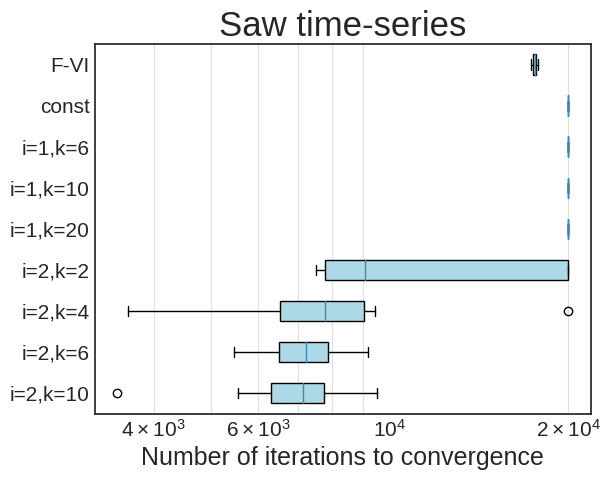

In [44]:
plt.boxplot(iter_to_conv_plot, labels=algo_names, patch_artist=True,
             boxprops = dict(facecolor = "lightblue"),
             vert=False)
plt.xscale("log")
plt.grid(which='minor', visible='true', c='grey', alpha = 0.25)
plt.gca().invert_yaxis()

# plt.xticks(rotation=45)
plt.title("Saw time-series")
# plt.ylabel("VI algorithm")
plt.xlabel("Number of iterations to convergence")

plt.savefig("to_discuss/conv_sawtime_boxplot.pdf", bbox_inches='tight')
plt.show()